In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/188-million-us-wildfires/FPA_FOD_20170508.sqlite
/kaggle/input/train-data/train.csv


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

188-million-us-wildfires
train-data



### establishing a connection with the database file.

In [3]:
fires = pd.read_csv('/kaggle/input/train-data/train.csv')
fires.head()
fires.drop_duplicates() # removing the duplicate rows

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,FIPS_NAME,Shape,FIRE_SIZE_SCALED
0,1623287,201658541,SFO-NY-2012-NY4414-2012-050012,NONFED,ST-NASF,ST/C&L,USNYNYX,Fire Department of New York,NY4414,Fire Department of New York,...,0.1,A,41.147000,-73.927000,14.0,MISSING/NOT SPECIFIED,NY,Rockland,b'\x00\x01\xad\x10\x00\x00\x14\xd9\xce\xf7S{R\...,1.647431e-07
1,1569451,201435787,FS-1509063,FED,FS-FIRESTAT,FS,USORUPF,Umpqua National Forest,0615,Umpqua National Forest,...,0.1,A,43.084444,-122.617778,5.0,USFS,OR,Douglas,b'\x00\x01\xad\x10\x00\x00\xe8R\xd0\xab\x89\xa...,1.647431e-07
2,329243,336663,W-522697,FED,DOI-WFMI,BLM,USIDTFD,Twin Falls District,IDJRD,Jarbidge Field Office,...,98.6,C,42.741900,-114.848900,1.0,BLM,ID,Twin Falls,b'\x00\x01\xad\x10\x00\x00\xc0d\xaa`T\xb6\\\xc...,1.624529e-04
3,1218664,1476284,W-603889,FED,DOI-WFMI,BLM,USUTSLD,Salt Lake Field Office,UTSLD,Salt Lake Field Office,...,0.5,B,40.293300,-111.977500,8.0,PRIVATE,UT,Utah,b'\x00\x01\xad\x10\x00\x00\xc0\xf5(\\\x8f\xfe[...,8.237814e-07
4,1749209,300090002,SFO-2014GAGAS-FY2014-Wilcox-004,NONFED,ST-NASF,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,Georgia Forestry Commission,...,11.8,C,31.949458,-83.289372,8.0,PRIVATE,GA,Wilcox,b'\x00\x01\xad\x10\x00\x00TQ\x0f\x13\x85\xd2T\...,1.944161e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713600,261367,266414,W-536509,FED,DOI-WFMI,BIA,USSDCRA,Cheyenne River Agency,SDCRA,Cheyenne River Agency,...,1.8,B,45.202500,-101.497700,9.0,TRIBAL,SD,Unknown,b'\x00\x01\xad\x10\x00\x00\x04\xce\x19Q\xda_Y\...,2.965656e-06
713601,372213,384326,FWS-2007MSMSRC9G9,FED,FWS-FMIS,FWS,USMSMSR,Mississippi Sandhill Crane National Wildlife R...,MSMSR,Mississippi Sandhill Crane National Wildlife R...,...,0.2,A,30.440000,-88.639444,4.0,FWS,MS,Unknown,"b'\x00\x01\xad\x10\x00\x00,Z_\xa8\xec(V\xc0\x8...",3.295027e-07
713602,132152,133461,FS-358879,FED,FS-FIRESTAT,FS,USIDSCF,Salmon-Challis National Forest,0413,Salmon-Challis National Forest,...,0.2,A,44.906667,-114.291111,5.0,USFS,ID,Unknown,b'\x00\x01\xad\x10\x00\x00\xf0<~\x90\xa1\x92\\...,3.295027e-07
713603,1498456,201171855,2011SCSCS12FF0002,NONFED,ST-NASF,ST/C&L,USSCSCS,South Carolina Forestry Commission,SCSCS,South Carolina Forestry Commission,...,0.3,B,33.893082,-79.788811,8.0,PRIVATE,SC,Florence,b'\x00\x01\xad\x10\x00\x00d\xee!\xe1{\xf2S\xc0...,4.942622e-07


In [4]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713605 entries, 0 to 713604
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   OBJECTID                    713605 non-null  int64  
 1   FOD_ID                      713605 non-null  int64  
 2   FPA_ID                      713605 non-null  object 
 3   SOURCE_SYSTEM_TYPE          713605 non-null  object 
 4   SOURCE_SYSTEM               713605 non-null  object 
 5   NWCG_REPORTING_AGENCY       713605 non-null  object 
 6   NWCG_REPORTING_UNIT_ID      713605 non-null  object 
 7   NWCG_REPORTING_UNIT_NAME    713605 non-null  object 
 8   SOURCE_REPORTING_UNIT       713605 non-null  object 
 9   SOURCE_REPORTING_UNIT_NAME  713605 non-null  object 
 10  FIRE_NAME                   711357 non-null  object 
 11  FIRE_YEAR                   713605 non-null  int64  
 12  DISCOVERY_DATE              713605 non-null  float64
 13  DISCOVERY_DOY 

In [5]:
fires.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'FIRE_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE',
       'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR',
       'STATE', 'FIPS_NAME', 'Shape', 'FIRE_SIZE_SCALED'],
      dtype='object')

### Breaking down the data into the 7 FIRE_SIZE_CLASSES to understand the severity of the issue.

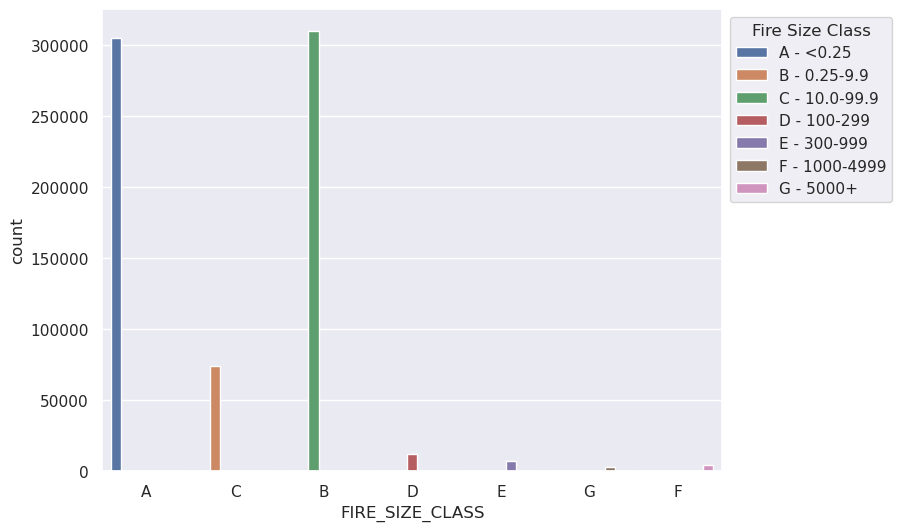

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x='FIRE_SIZE_CLASS', hue='FIRE_SIZE_CLASS', data=fires, ax=ax)

# Add legends
legend_labels = ['A - <0.25', 'B - 0.25-9.9', 'C - 10.0-99.9', 'D - 100-299', 'E - 300-999', 'F - 1000-4999', 'G - 5000+']
ax.legend(title='Fire Size Class', labels=legend_labels, bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()


### DISCOVERY_DOY is the day of the year the fire was confirmed

In [7]:
fire_trend=fires.dropna()
fire_trend=fires.groupby('FIRE_YEAR').DISCOVERY_DOY.count()
print(fire_trend)

FIRE_YEAR
1992    28876
1993    26784
1994    32783
1995    29438
1996    33404
1997    20772
1998    19340
1999    23709
2000    29998
2001    29676
2002    28272
2003    25351
2004    22249
2005    26677
2006    30410
2007    28553
2008    23134
2009    26562
2010    23529
2011    46721
2012    40879
2013    36063
2014    38394
2015    42031
Name: DISCOVERY_DOY, dtype: int64


### Number of cases reported per year

B    309505
A    304515
C     74016
D     11746
E      6864
F      4460
G      2499
Name: FIRE_SIZE_CLASS, dtype: int64


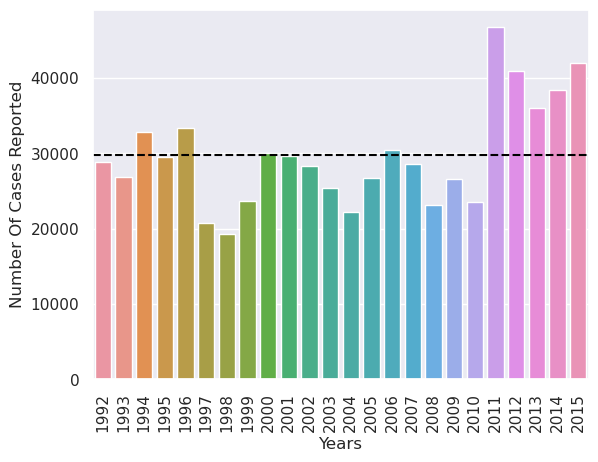

In [8]:
grouped_by_size= fires.FIRE_SIZE_CLASS.value_counts()
print(grouped_by_size)

graph=sns.barplot(x=fire_trend.index,y=fire_trend)
plt.xticks(rotation=90)
plt.xlabel('Years')
plt.ylabel('Number Of Cases Reported')
mean=fire_trend.mean()
graph.axhline(y=mean,color='black',linestyle='--')
plt.show()

### Number of cases reported per class

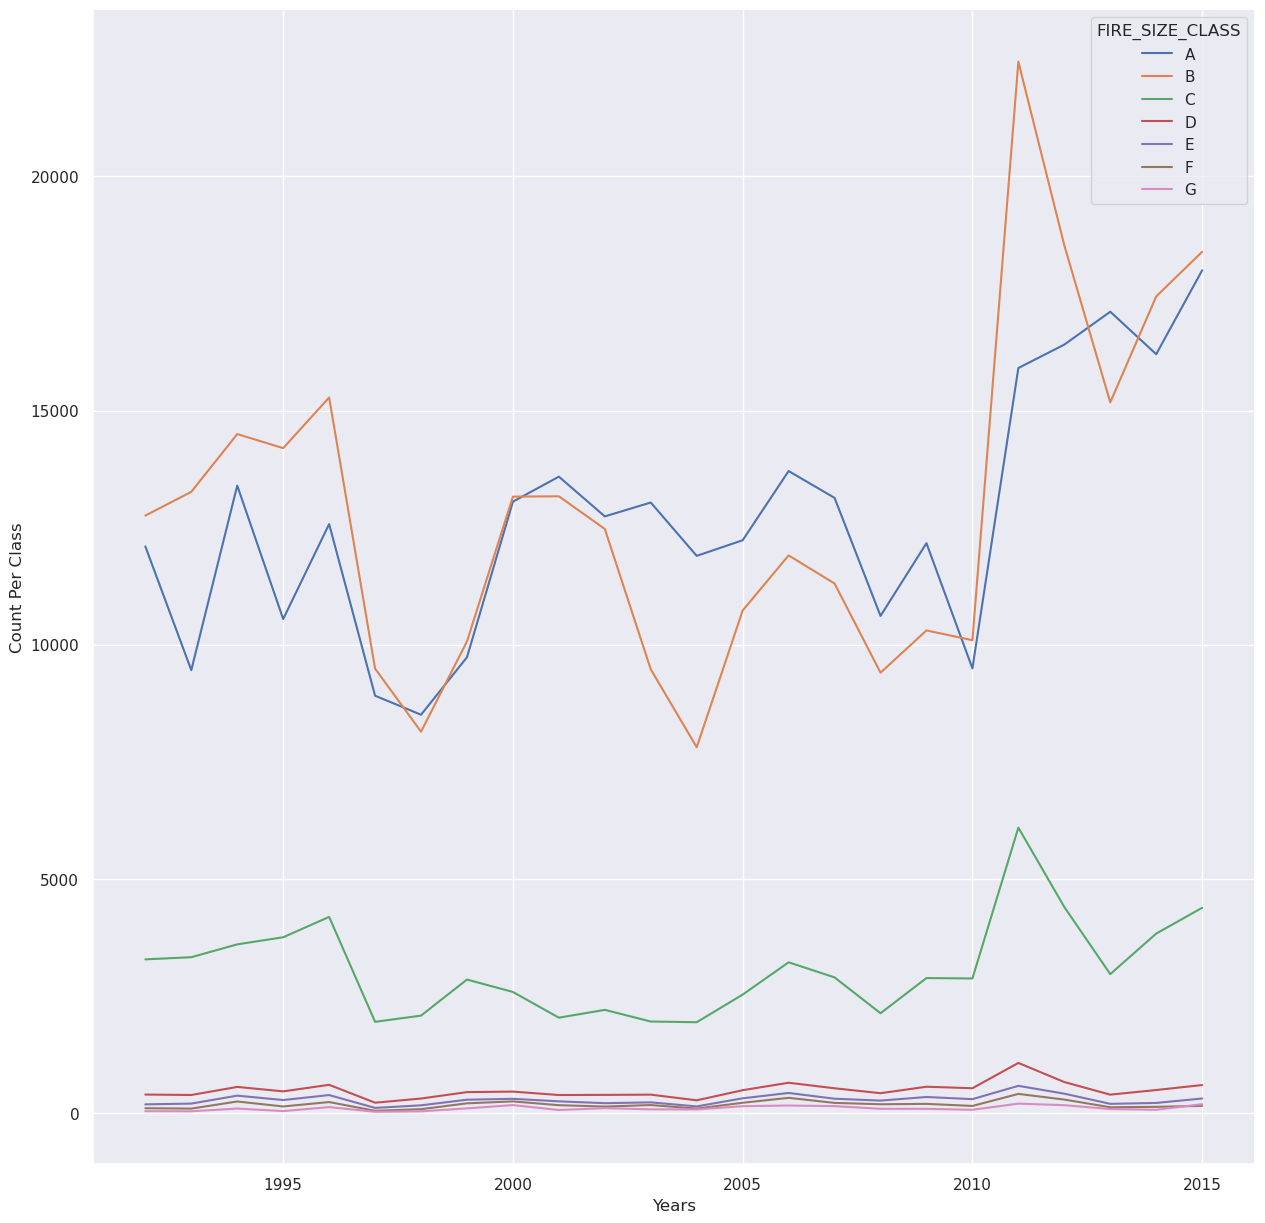

FIRE_SIZE_CLASS      A      B     C     D    E    F    G
FIRE_YEAR                                               
1992             12099  12757  3284   398  189  106   43
1993              9457  13264  3330   389  205   98   41
1994             13397  14497  3604   561  375  250   99
1995             10549  14197  3756   466  281  144   45
1996             12575  15278  4190   606  387  238  130
1997              8912   9490  1951   224  113   51   31
1998              8506   8144  2083   313  168   86   40
1999              9733  10071  2853   450  288  211  103
2000             13055  13162  2588   461  307  252  173
2001             13588  13169  2039   388  253  171   68
2002             12740  12471  2206   391  214  142  108
2003             13036   9474  1957   396  231  174   83
2004             11897   7812  1942   275  145   98   80
2005             12231  10732  2532   491  318  223  150
2006             13708  11907  3221   650  432  328  164
2007             13135  11307  

In [9]:
fire_grp=fires[['FIRE_YEAR','FIRE_SIZE_CLASS']]
fire_grp.groupby('FIRE_YEAR').FIRE_SIZE_CLASS.value_counts().unstack().plot(figsize=(15,15))
plt.xlabel('Years')
plt.ylabel('Count Per Class')
plt.show()

fire_g=fire_grp.groupby('FIRE_YEAR').FIRE_SIZE_CLASS.value_counts()
print(fire_g.unstack())

#### To create our data frame, we can execute a select query on the database. In order to obtain information about the tables and data provided, I utilized DB Browser for SQLite. As I am only interested in specific columns, I will be selecting only those columns necessary for our purposes.

In [10]:
df = fires.copy()
selected_cols = ['FIRE_YEAR','STAT_CAUSE_DESCR','LATITUDE','LONGITUDE','STATE','DISCOVERY_DATE','FIRE_SIZE']
df = df[selected_cols]
print(df.head(5))

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2012    Miscellaneous  41.147000  -73.927000    NY       2455997.5   
1       2012         Campfire  43.084444 -122.617778    OR       2456151.5   
2       2006        Lightning  42.741900 -114.848900    ID       2453917.5   
3       2010    Miscellaneous  40.293300 -111.977500    UT       2455388.5   
4       2014   Debris Burning  31.949458  -83.289372    GA       2456681.5   

   FIRE_SIZE  
0        0.1  
1        0.1  
2       98.6  
3        0.5  
4       11.8  


#### The DISCOVERY_DATE attribute is currently presented in the Julian Date format. To make it more accessible, I aim to convert this attribute into Gregorian dates, which is the conventional date format used in our daily lives. Once I have successfully converted the date format, I will utilize the Gregorian date to extract more specific data, including the month and the day of the week.

In [11]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(df.head()) #check the data



   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2012    Miscellaneous  41.147000  -73.927000    NY       2455997.5   
1       2012         Campfire  43.084444 -122.617778    OR       2456151.5   
2       2006        Lightning  42.741900 -114.848900    ID       2453917.5   
3       2010    Miscellaneous  40.293300 -111.977500    UT       2455388.5   
4       2014   Debris Burning  31.949458  -83.289372    GA       2456681.5   

   FIRE_SIZE       DATE  
0        0.1 2012-03-11  
1        0.1 2012-08-12  
2       98.6 2006-07-01  
3        0.5 2010-07-11  
4       11.8 2014-01-24  


In [12]:
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
df_orig = df.copy() #I will use this copy later
print(df.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2012    Miscellaneous  41.147000  -73.927000    NY       2455997.5   
1       2012         Campfire  43.084444 -122.617778    OR       2456151.5   
2       2006        Lightning  42.741900 -114.848900    ID       2453917.5   
3       2010    Miscellaneous  40.293300 -111.977500    UT       2455388.5   
4       2014   Debris Burning  31.949458  -83.289372    GA       2456681.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0        0.1 2012-03-11      3      Sunday  
1        0.1 2012-08-12      8      Sunday  
2       98.6 2006-07-01      7    Saturday  
3        0.5 2010-07-11      7      Sunday  
4       11.8 2014-01-24      1      Friday  


#### Count of Fires Larger than 500 Acres burned by Cause

In [13]:
import altair as alt
FIRE_SIZE_THRESHOLD = 500

big_fires = fires[fires.FIRE_SIZE>FIRE_SIZE_THRESHOLD]
big_fire_count = pd.DataFrame(big_fires.groupby(['STAT_CAUSE_DESCR']).OBJECTID.count().sort_values(ascending=False)).reset_index()
big_fire_count.rename(columns={'OBJECTID': 'num_fires'}, inplace=True)
alt.Chart(big_fire_count).mark_bar().encode(
    alt.X('STAT_CAUSE_DESCR', sort='-y', title=None),
    alt.Y('num_fires', title='Number of Fires'),
).properties(title=f'Count of Fires Larger than {FIRE_SIZE_THRESHOLD} Acres',
    width=600,
    height=300
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)

alt.Chart(...)

#### Number of Acres Burned by each Cause

In [15]:
acres_by_cause = pd.DataFrame(fires.groupby(['STAT_CAUSE_DESCR']).FIRE_SIZE.sum().sort_values(ascending=False)).reset_index()
acres_by_cause.rename(columns={'FIRE_SIZE': 'Acres'}, inplace=True)
alt.Chart(acres_by_cause).mark_bar().encode(
    alt.X('STAT_CAUSE_DESCR', sort='-y', title=None),
    alt.Y('Acres'),
).properties(
    title=f'Acres Burned by Cause',
    width=600,
    height=300
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)


alt.Chart(...)

#### Number of Acres Burned by Year

In [16]:
acres_by_year = pd.DataFrame(fires.groupby(['FIRE_YEAR']).FIRE_SIZE.sum().sort_values(ascending=False)).reset_index()
acres_by_year.rename(columns={'FIRE_SIZE': 'Acres'}, inplace=True)

alt.Chart(acres_by_year).mark_line().encode(
    alt.X('FIRE_YEAR:N', title=None),
    alt.Y('Acres'),
).properties(
    title=f'Acres Burned by Year',
    width=600,
    height=300,
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)

alt.Chart(...)

In [17]:
frac_by_lightning = (fires.query('STAT_CAUSE_DESCR=="Lightning"').groupby(['FIRE_YEAR']).FIRE_SIZE.sum() / acres_by_year.set_index('FIRE_YEAR').Acres)
frac_by_lightning.name = 'frac_acres_lightning'
frac_by_lightning = pd.DataFrame(frac_by_lightning).reset_index()

alt.Chart(frac_by_lightning).mark_line().encode(
    alt.X('FIRE_YEAR:N', title=None),
    alt.Y('frac_acres_lightning', title=None),
).properties(
    title=f'Fraction of Burned Acres Caused By Lightning Induced Fires',
    width=600,
    height=300
).configure_axis(
    labelFontSize=14,
    titleFontSize=14
)

alt.Chart(...)

#### Can we identify any correlation between the occurrence of fires and specific days of the week? By analyzing the data, we can examine whether there are any noticeable patterns or trends in the frequency of fires on different days.

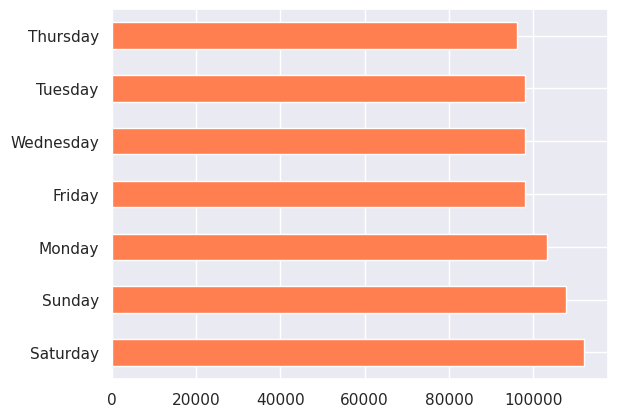

In [18]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

#### Which states have the most fires?

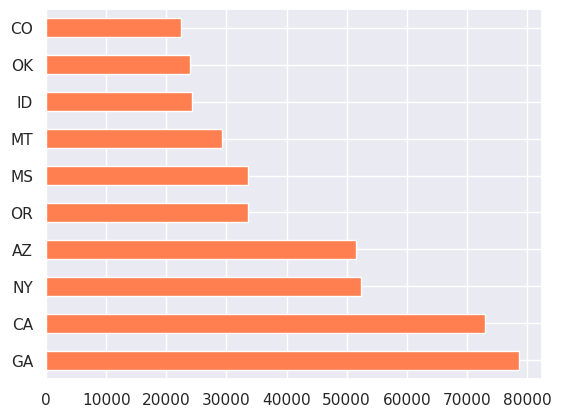

In [19]:
df['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

In [20]:
# Taking a further look into statistical causes of fires in relation to how many acres burned for each year
wildfire_cause_fire = fires[['STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'FIRE_YEAR', 'FIRE_SIZE']]
fire_acres = wildfire_cause_fire[['STAT_CAUSE_DESCR', 'FIRE_YEAR', 'FIRE_SIZE']] \
    .groupby(['STAT_CAUSE_DESCR', 'FIRE_YEAR']).agg(FIRE_SIZE=pd.NamedAgg(column='FIRE_SIZE', aggfunc='sum')).reset_index()

In [21]:
# Note: Bar plot creation modified by towarddatascience bar-chart-race
import plotly.graph_objects as go
initial_year = fire_acres['FIRE_YEAR'].min()
final_year = fire_acres['FIRE_YEAR'].max()
year_frames = []

for year in range(initial_year, final_year):
    year_data = fire_acres.loc[fire_acres['FIRE_YEAR'] == year]
    max_range = year_data['FIRE_SIZE'].max()
    year_frames.append(go.Frame(data= [go.Bar( x = year_data['STAT_CAUSE_DESCR'], 
                y = year_data['FIRE_SIZE'], cliponaxis=False, text = year_data['FIRE_SIZE'], textposition='outside', 
                                              hoverinfo='none', texttemplate= '%{text: .2s}')],
                layout=go.Layout(title= "Wildfire damage: " + str(year),
                    font={'size': 14}, xaxis= {'showline': False, 'visible' : True},
                    yaxis = {'showline' : False, 'visible' : True, 
                             'autorange' : True, 'fixedrange' : False, 'range': (0, max_range + 100000)}, bargap = 0.15
                                )))
init = fire_acres.loc[fire_acres['FIRE_YEAR'] == initial_year]
max_range = fire_acres['FIRE_SIZE'].max()
fig = go.Figure(
    data = [go.Bar(x = init['STAT_CAUSE_DESCR'], y = init['FIRE_SIZE'],
            cliponaxis=False, hoverinfo='none', textposition='outside', text = init['FIRE_SIZE'],
                  texttemplate= '%{text: .2s}')],
    layout=go.Layout(
        yaxis = {'showline' : False, 'visible' : True, 
                'autorange' : True, 'fixedrange' : False, 'range' : (0, max_range + 100000)}, bargap = 0.15,
        xaxis= {'showline': False, 'visible' : True},
        updatemenus=[dict(type="buttons",
                         buttons=[dict(label="Play", method = "animate",
                        args = [None, {"frame" : {"duration": 2000, "redraw" :True}, "fromcurrent": True}]),
                        dict(label="Stop", method = "animate",
                        args = [[None], {"frame": {"duration": 0, "redraw": False}, "mode" : "immediate", "transition": {"duration" : 40}}])])]
    ),
    frames = list(year_frames)
)
fig.update_yaxes(automargin=True)
fig.show()

In [22]:
fire_map=fires[fires['FIRE_YEAR']==2015]
fire_map=fire_map.STATE.value_counts()
print(fire_map.values)
print(fire_map.keys())

[4742 4277 4178 1890 1866 1861 1792 1705 1663 1440 1367 1109 1021  916
  913  739  731  717  684  629  591  556  541  507  503  474  467  446
  432  418  407  400  372  346  337  321  182  137  108   79   56   24
   22   20   14   13   12    3    3]
Index(['CA', 'KS', 'NY', 'OR', 'GA', 'FL', 'NC', 'AZ', 'MS', 'MN', 'MT', 'WA',
       'SC', 'AR', 'OK', 'LA', 'WI', 'TX', 'ID', 'PA', 'KY', 'MO', 'ND', 'WV',
       'NM', 'NE', 'WY', 'UT', 'TN', 'SD', 'CO', 'NV', 'OH', 'AK', 'NJ', 'ME',
       'MA', 'MI', 'MD', 'IL', 'RI', 'IA', 'PR', 'VA', 'DE', 'AL', 'IN', 'HI',
       'DC'],
      dtype='object')


In [23]:
fires_discovery=fires[['DISCOVERY_TIME','FIRE_YEAR']]
print(fires_discovery)
print(fires_discovery.FIRE_YEAR.unique())
#checkiing for missing values
print(fires_discovery.isna().any())

        DISCOVERY_TIME  FIRE_YEAR
0                 1916       2012
1                 1702       2012
2                 2240       2006
3                 1403       2010
4                 1246       2014
...                ...        ...
713600            1045       2006
713601            1715       2007
713602            1230       2000
713603            1450       2011
713604            1430       1999

[713605 rows x 2 columns]
[2012 2006 2010 2014 2015 1998 2004 1993 2000 2008 1992 2007 1999 1997
 2011 2005 1994 1995 2013 1996 2009 2002 2003 2001]
DISCOVERY_TIME    False
FIRE_YEAR         False
dtype: bool


There seem to be values missing in cloumn- DISCOVERY_TIME. so lets first get rid of those rows

In [24]:
fires_discovery_updated=fires_discovery.dropna().reset_index(drop=True)
print(fires_discovery_updated.isna().any())
print(fires_discovery_updated)

DISCOVERY_TIME    False
FIRE_YEAR         False
dtype: bool
        DISCOVERY_TIME  FIRE_YEAR
0                 1916       2012
1                 1702       2012
2                 2240       2006
3                 1403       2010
4                 1246       2014
...                ...        ...
713600            1045       2006
713601            1715       2007
713602            1230       2000
713603            1450       2011
713604            1430       1999

[713605 rows x 2 columns]


In [27]:
# Split the DISCOVERY_TIME into hour and minute columns
fires_discovery_updated['DISCOVERY_HOUR'] = fires_discovery_updated['DISCOVERY_TIME'] // 100
fires_discovery_updated['DISCOVERY_MINUTE'] = fires_discovery_updated['DISCOVERY_TIME'] % 100

# Create a time object using the hour and minute columns
fires_discovery_updated['DISCOVERY_TIME_OBJECT'] = fires_discovery_updated.apply(
    lambda x: dt.time(x['DISCOVERY_HOUR'], x['DISCOVERY_MINUTE']), axis=1)

# Convert the time object to 12-hour standard format
fires_discovery_updated['DISCOVERY_STD_12'] = fires_discovery_updated['DISCOVERY_TIME_OBJECT'].apply(
    lambda x: x.strftime('%I:%M %p'))


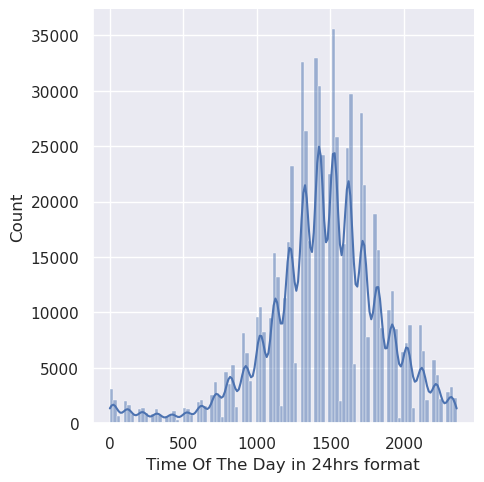

In [28]:
import seaborn as sns
sns.displot(x=fires_discovery_updated['DISCOVERY_TIME_INT'],bins=100,kde=True)
plt.xlabel('Time Of The Day in 24hrs format')
plt.show()

In [29]:
import folium
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from geopy.distance import great_circle

In [30]:
# define the minimum number of fires in a cluster and the maximum distance between fires in a cluster
min_cluster_size = 10
max_cluster_distance = 1000 # in meters

In [32]:
# create a list of fire coordinates
coords = fires[['LATITUDE', 'LONGITUDE']].values

In [33]:
# compute the clusters using DBSCAN
# db = DBSCAN(eps=max_cluster_distance/1000, min_samples=min_cluster_size/2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
# db = DBSCAN(eps=max_cluster_distance/1000, min_samples=min_cluster_size/2, algorithm='ball_tree', metric='haversine', memory='./').fit(np.radians(coords))
kmeans = MiniBatchKMeans(n_clusters=1000, batch_size=10000).fit(np.radians(coords))

# df_interest['cluster'] = db.labels_
fires['cluster'] = kmeans.labels_

In [35]:
# create a map centered on the USA
map = folium.Map(location=[37, -102], zoom_start=4)

# loop through the clusters and add markers for each cluster with the size indicated by the marker color
for cluster in fires['cluster'].unique():
    if cluster != -1:
        cluster_df = fires[fires['cluster']==cluster]
        center_lat, center_lon = cluster_df[['LATITUDE', 'LONGITUDE']].mean()
        size = cluster_df['FIRE_SIZE_SCALED'].sum()
        folium.CircleMarker(location=[center_lat, center_lon], 
                            radius=size, 
                            color='red', 
                            fill=True, 
                            fill_color='red', 
                            fill_opacity=0.5).add_to(map)

# display the map
map

In [46]:
# Calculate the correlations among numerical features.
cat=['STATE','FIPS_NAME']
num=['FIRE_YEAR',"DISCOVERY_DOY","DISCOVERY_TIME","CONT_DOY","CONT_TIME","FIRE_SIZE","LATITUDE","LONGITUDE"]
corr_df=fires[num] 
cor= corr_df.corr(method='pearson')
cor

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE
FIRE_YEAR,1.000000,-0.028351,0.024019,-0.022638,0.003430,0.005620,0.044036,0.095397
DISCOVERY_DOY,-0.028351,1.000000,-0.042183,0.994469,-0.032183,0.006135,0.154359,-0.272606
DISCOVERY_TIME,0.024019,-0.042183,1.000000,-0.040616,0.549562,0.001212,0.024507,0.061885
CONT_DOY,-0.022638,0.994469,-0.040616,1.000000,-0.035900,0.023729,0.165427,-0.278872
CONT_TIME,0.003430,-0.032183,0.549562,-0.035900,1.000000,-0.002424,-0.020091,0.037647
FIRE_SIZE,0.005620,0.006135,0.001212,0.023729,-0.002424,1.000000,0.049364,-0.048773
LATITUDE,0.044036,0.154359,0.024507,0.165427,-0.020091,0.049364,1.000000,-0.365515
LONGITUDE,0.095397,-0.272606,0.061885,-0.278872,0.037647,-0.048773,-0.365515,1.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



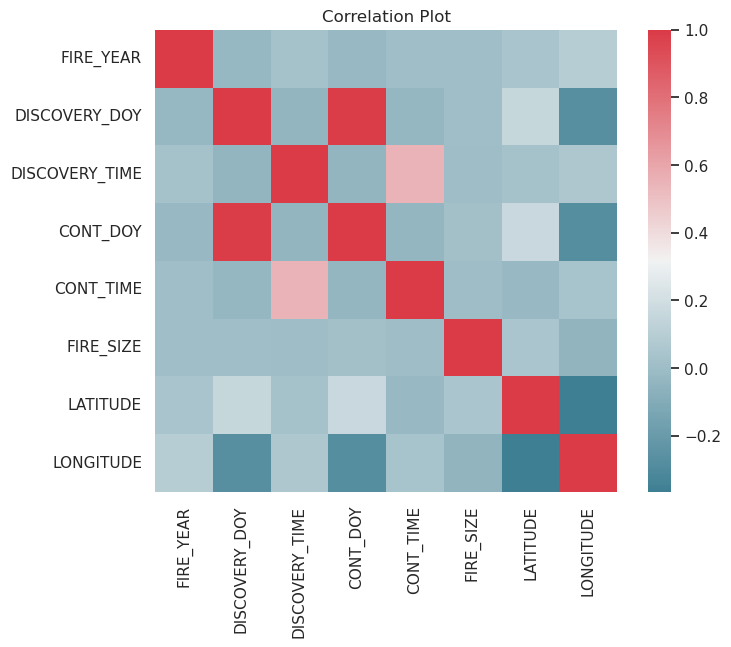

In [47]:
# Visualize the pair-wise correlations.
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()